In [10]:
transformers.__version__

'4.41.2'

In [11]:
accelerate.__version__

'0.31.0'

In [2]:
!pip install transformers

In [6]:
import transformers

In [4]:
!pip install accelerate

import accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [12]:
!pip install pandas
!pip install nltk
!pip install emoji

import pandas as pd
import re
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from transformers import BertTokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 10.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
df = pd.read_csv('/thelinkof/cleaned_movie_data_comment.csv')

In [14]:
#Gürültü verilerinin temizlenmesi
def clean_text(text):
    if not isinstance(text, str):
        return ''  # Metin olmayan (örneğin NaN) değerleri boş string ile değiştir
    # HTML etiketlerini kaldırma
    text = re.sub(r'<.*?>', '', text)
    # Emojileri kaldırma
    text = emoji.replace_emoji(text, replace='')
    # Noktalama işaretlerini ve sayıları kaldırma
    text = re.sub(r'[^\w\s]', '', text)
    # Boşlukları düzenleme
    text = re.sub(r'\s+', ' ', text)
    # Küçük harfe çevirme
    text = text.lower().strip()
    return text

# Temizleme işlemini uygulama
df['cleaned_comment'] = df['comment_text'].apply(clean_text)



In [15]:
#Tokenizasyon ve Stop-Word Temizleme
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
stop_words = set(stopwords.words('turkish'))

def tokenize_and_remove_stop_words(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    # 512 token sınırını aşmamak için
    return tokens[:512]

df['tokens'] = df['cleaned_comment'].apply(tokenize_and_remove_stop_words)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/251k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

In [16]:
#Verisetinin kayıt edilmesi
df.to_csv('/thelinkof/processed_movie_comments.csv', index=False)


In [17]:
# Install required libraries
!pip install transformers torch scikit-learn


In [18]:
# Import necessary libraries
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
# Define the dataset class
class TurkishMovieCommentsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        # Ensure all texts are strings and handle any NaN or non-string types
        self.texts = [str(text) for text in texts if isinstance(text, str)]
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [20]:
# Load and preprocess data
df = pd.read_csv('/thelinkof/processed_movie_comments.csv')
df['labels'] = df['comment_rating'].apply(lambda x: 2 if x >= 7 else (1 if x >= 4 else 0))
df['cleaned_comment'] = df['cleaned_comment'].astype(str)  # Convert all comments to strings

In [21]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-turkish-cased', num_labels=3)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Prepare datasets
train_dataset = TurkishMovieCommentsDataset(train_df['cleaned_comment'].tolist(), train_df['labels'].tolist(), tokenizer)
test_dataset = TurkishMovieCommentsDataset(test_df['cleaned_comment'].tolist(), test_df['labels'].tolist(), tokenizer)

In [24]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./results_dbmdz_bert_base_turkish_cased',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_dir='./logs_dbmdz_bert_base_turkish_cased',
    logging_steps=50,
)

In [25]:
# Initialize and run trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [26]:
# Train and evaluate the model
trainer.train()
eval_result = trainer.evaluate()
print(f"Results: {eval_result}")


Epoch,Training Loss,Validation Loss
1,0.297900,0.431822
2,0.265300,0.342438
3,0.119000,0.478662


Results: {'eval_loss': 0.47866156697273254, 'eval_runtime': 67.5753, 'eval_samples_per_second': 69.937, 'eval_steps_per_second': 1.095, 'epoch': 3.0}


In [27]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
import matplotlib.pyplot as plt
from torch import no_grad


In [28]:
# Değerlendirme fonksiyonu
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'],
                      'attention_mask': batch['attention_mask'],
                      'labels': batch['labels']}
            outputs = model(**inputs)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(batch['labels'].tolist())

    return predictions, true_labels


In [30]:
# Test verileri için DataLoader hazırlanması
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [32]:
# Modeli GPU'ya taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Değerlendirme fonksiyonunu güncelleyin
def evaluate(model, dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Batch verilerini GPU'ya taşıyın
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Model tahminlerini alın
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(labels.tolist())

    return predictions, true_labels


In [33]:
# Modelin değerlendirilmesi
predictions, true_labels = evaluate(model, test_loader)

In [34]:
# Metriklerin hesaplanması
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
precision = precision_score(true_labels, predictions, average='weighted')
roc_auc = roc_auc_score(pd.get_dummies(true_labels), pd.get_dummies(predictions), multi_class='ovr')


In [35]:
# Metriklerin çizdirilmesi
metrics = {'Accuracy': accuracy, 'F1 Score': f1, 'Recall': recall, 'Precision': precision, 'ROC AUC': roc_auc}
metrics_names = list(metrics.keys())
metrics_values = list(metrics.values())

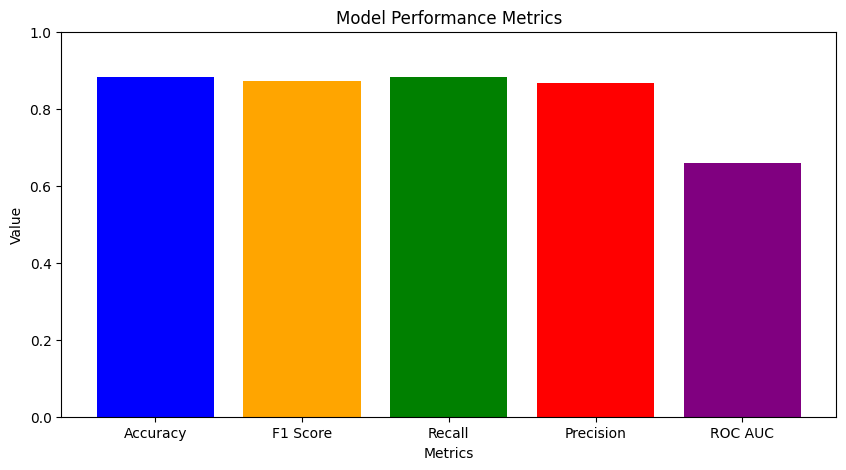

In [36]:
plt.figure(figsize=(10, 5))
plt.bar(metrics_names, metrics_values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Model Performance Metrics')
plt.ylim(0, 1)
plt.show()

In [37]:
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

Accuracy: 0.8815
F1 Score: 0.8719
Recall: 0.8815
Precision: 0.8658
ROC AUC: 0.6588
